In [1]:
include("../code/bp_full.jl")
include("../code/bp.jl")
include("../../telegram/notifications.jl")

using Base.Threads

# 1. Effect of leaves

In [2]:
function buildgraph(R, f1, f3; tol=1e-2, B=0) 
    f2 = 1.0-f1-f3
    α = 1-R
    k = floor(Int, (2-f1+f3)/α)
    s = k+1-(2-f1+f3)/α
    K = [fill(0,k-1); s; 1-s]
    Λ = [f1, f2, f3]
    m, n, nedges, rho, lambda = valid_degrees(K,Λ,3*5*7, B=1)
    if B==0
        B = 10^max(0, 3-round(Int,log10(n)))
    end
    m, n, nedges, rho, lambda = valid_degrees(K,Λ,3*5*7, B=B)
    @assert isapprox(Λ, lambda, atol=tol)
    @assert isapprox(lambda[1], f1, atol=tol)
    @assert isapprox(R, rate(lambda, rho), atol=tol)
    m, n, nedges, rho, lambda
end

function ms_dec(n, m, nedges, K, Λ; verbose=true, maxiter=10^2, Tmax=1, kw...)
    efield = [(.0,.0) for _ in 1:n]
    s = zeros(Int, n)
    vars = rand(1:n, n*2÷3); factors=rand(1:m-1, m*2÷3)
    Ht = ldpc_matrix(n, m, nedges, Λ, K; accept_multi_edges=false)[:,1:end-1]
    H = permutedims(Ht)
    s .= rand((-1.,1.),n)
    d = Inf
    for t in 1:Tmax
        efield .= [(si,-si).+ 1e-5.*(randn(),randn()) for si in s]
        ms = BPFull(H, efield)
        ε, iters = iteration_ms!(ms, maxiter=maxiter;
            vars=vars, factors=factors, kw...)
        nunsat, ovl, dist = performance(ms, s)
        verbose && @show nunsat, ovl, dist
        flush(stdout)
        if nunsat!=0
            B,indep = findbasis(H, Ht)
            x = argmax.(ms.belief) .== 2
            σ = fix_indep!(x, B, indep)   
            d = min(d, distortion(σ,s))
        else
            d = min(d, dist)
        end
    end
    d
end

ms_dec (generic function with 1 method)

In [3]:
R = 0.5
f3 = 0.2
f1s = [0, 0.01, 0.02, 0.03]
Bs = [200, 10, 10, 30]

for (i,f1) in enumerate(f1s)
    m, n, nedges, rho, lambda = buildgraph(R, f1, f3, B=Bs[i])
    @show f1, n
end

(f1, n) = (0.0, 2000)
(f1, n) = (0.01, 2100)
(f1, n) = (0.02, 2100)
(f1, n) = (0.03, 2100)


In [ ]:
navg = 100
Tmax = 20
D_ms = [zeros(navg) for _ in f1s]
R_ms = zeros(length(f1s))

@telegram "MaxSum" for i in eachindex(f1s)
    println("Degree profile $i of ", length(f1s))
    m, n, nedges, rho, lambda = buildgraph(R, f1s[i], f3)
    R_ms[i] = 1 - m/n
    @threads for j in 1:navg
        D_ms[i][j] = ms_dec(n, m, nedges, rho, lambda; Tmax=Tmax, maxiter=5*10^3, 
            rein=1e-3, verbose=false)
    end 
end

Degree profile 1 of 4


In [ ]:
pl = plot_rdb();
for i in eachindex(f1s)
    lab = "MS+rein - f1=$(f1s[i])"
    scatter!(pl, repeat([R_ms[i]], navg), D_ms[i], label=lab, ms=3)
end
pl2 = plot_rdb();
for i in eachindex(f1s)
    lab = "MS+rein - f1=$(f1s[i])"
    scatter!(pl2, [R_ms[i]], [mean(D_ms[i])], label=lab, ms=3)
end
pl3 = plot(pl, pl2, size=(900,300), margin=5Plots.mm)

In [ ]:
scatter(f1s, mean.(D_ms), xlabel="f1", ylabel="dist", size=(300,300), yerr=std.(D_ms)/sqrt(navg),
    title="Effect of leaves - R=$(R_ms[1]), f3=$f3", titlefontsize=9, label="MS+rein")

In [16]:
savefig("ms_rein_leaves.pdf")

In [14]:
D_ms_avg = mean.(D_ms)
# D_ms_std = std.(D_ms)/sqrt(navg)

4-element Vector{Float64}:
 0.13592
 0.13590476190476192
 0.13543333333333335
 0.13715714285714287

# 2. MS+rein in the RSB regime

In [15]:
function ms_rein(f1, f2, n; Tmax=1, maxiter=10^3, rein=1e-4)
    f3 = 1 - f1 -f2
    Lambda = [f1,f2,f3]
    K = [0,0,1]
    nedges = Int(round(n*sum(i*l for (i,l) in pairs(Lambda)), digits=10))
    m = Int(nedges/3)
    ds = zeros(Tmax); nunsats = zeros(Int, Tmax)
    R = 0.0
    for t in 1:Tmax
        s = rand((-1,1), n)
        efield = [float.((ss,-ss)) for ss in s]
        ms = bp_full(n, m, nedges, Lambda, K, efield)
        B, indep = findbasis_slow(Array(ms.H))
        R = size(B,2)/n
        ε, iters = iteration_ms!(ms, maxiter=maxiter, rein=rein)
        nunsats[t], ovl, ds[t] = performance(ms, s)
        if nunsats[t]!=0
            x = argmax.(ms.belief) .== 2
            σ = fix_indep!(x, B, indep) 
            @assert parity(ms.H, x)==0
            ds[t] = distortion(σ,s)
        end
    end
    minimum(ds), ds[argmin(nunsats)], R
end

ms_rein (generic function with 1 method)

In [ ]:
f1 = 1/100
n = 1800
f2s = [.35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95]
navg = 15
D_ms = [fill(NaN, navg) for f2 in f2s]
D_ms2 = [fill(NaN, navg) for f2 in f2s]
R_ms = zeros(length(f2s))

@telegram "MaxSum" for i in eachindex(f2s)
    println("#### Rate $i of $(length(f2s))")
   @threads for j in 1:navg
        D_ms[i][j], D_ms2[i][j], R_ms[i] = ms_rein(f1, f2s[i], n, Tmax=100, maxiter=5*10^3, rein=1e-4)
    end
    flush(stdout)
end

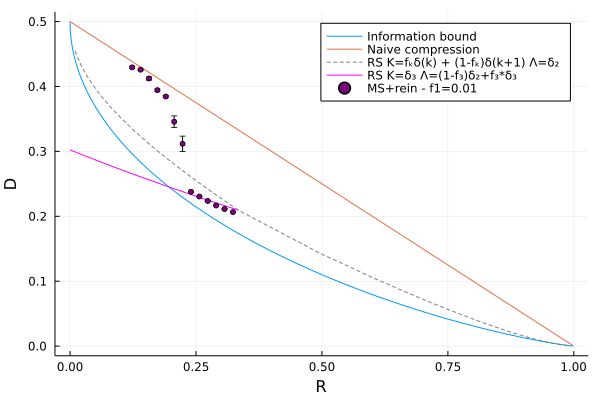

In [18]:
pl_ms2 = plot_rdb(; f3=true)
scatter!(pl_ms2, R_ms, mean.(D_ms), label="MS+rein - f1=$f1", ms=3, c=:purple, yerr=std.(D_ms)/sqrt(navg))

In [21]:
using DelimitedFiles
open("ms_rein.txt", "w") do f
   writedlm(f, [R_ms mean.(D_ms) std.(D_ms)/sqrt(navg)]) 
end

In [19]:
?writedlm

search: writedlm



```
writedlm(f, A, delim='\t'; opts)
```

Write `A` (a vector, matrix, or an iterable collection of iterable rows) as text to `f` (either a filename string or an `IO` stream) using the given delimiter `delim` (which defaults to tab, but can be any printable Julia object, typically a `Char` or `AbstractString`).

For example, two vectors `x` and `y` of the same length can be written as two columns of tab-delimited text to `f` by either `writedlm(f, [x y])` or by `writedlm(f, zip(x, y))`.

# Examples

```jldoctest
julia> using DelimitedFiles

julia> x = [1; 2; 3; 4];

julia> y = [5; 6; 7; 8];

julia> open("delim_file.txt", "w") do io
           writedlm(io, [x y])
       end

julia> readdlm("delim_file.txt", '\t', Int, '\n')
4×2 Matrix{Int64}:
 1  5
 2  6
 3  7
 4  8

julia> rm("delim_file.txt")
```
